# Dask Gateway: ATL06 S3 In-Place Processing → xdggs Summary Statistics

This notebook uses **Dask Gateway** to process Antarctic drainage basins in parallel.

**Architecture:**
- Converts Antarctic drainage basin polygons to morton cells (order 6) using morton indexing
  - `greedy_morton_polygon()` generates a spanning tree of the basin polygons
  - Expands each cell to order 6 using `generate_morton_children()`
  - Combines all children and removes duplicates for uniform parent cells
- Each worker processes one morton cell (order 6)
- Worker reads files directly from S3 using h5coro S3Driver (no downloads)
- In-memory spatial subsetting with morton indexing
- Worker calculates statistics for children (order 12)
- Worker writes zarr to S3: `s3://bucket/prefix/{morton}.zarr`

**Workflow per worker:**
1. Query CMR for granules intersecting morton cell # so-so
2. Read files in-place from S3 with spatial subsetting
3. Calculate summary statistics for child cells
4. Write xdggs-enabled zarr to S3

**Key requirements:**
- No local file downloads (better memory management)
- Spatial subsetting done during read (reduced data transfer)
- Handles empty results gracefully

We could do the spatial subsetting to a different grid, or use a different method than morton indexing. Here, we calculate the morton indices once, and then use them again for the spatial subset, since that combines to seperate spatial subset operations into a single numeric call. 

## 1. Imports and Configuration

In [1]:
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import PipInstall
from dask_gateway import Gateway

warnings.filterwarnings("ignore")

print("✓ Imports complete")

✓ Imports complete


## 2. Configuration

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

from mortie import generate_morton_children, geo2mort, greedy_morton_polygon

# Generate Antarctic morton cells at order 6 from drainage basin polygons
print("Loading Antarctic drainage basin polygons...")
filepath = "./Ant_Grounded_DrainageSystem_Polygons.txt"
antart = pd.read_csv(filepath, names=["Lat", "Lon", "basin"], sep=r"\s+")
print(f"  Loaded {len(antart):,} vertices across {antart['basin'].nunique()} basins")

print("\nConverting polygons to morton indices using greedy subdivision...")
morton_greedy, _ = greedy_morton_polygon(
    antart["Lat"].values, antart["Lon"].values, order=18, max_boxes=36, ordermax=5, verbose=True
)

print(f"\nGreedy method returned: {len(morton_greedy)} cells at various orders (≤6)")

# Expand all morton indices to order 6 using generate_morton_children
print("\nExpanding all cells to order 6...")
all_order6_cells = []
for morton in morton_greedy:
    # Generate children at order 6 for this parent morton
    children = generate_morton_children(morton, target_order=6)
    all_order6_cells.extend(children)

# Get unique order-6 cells
PARENT_MORTONS = np.unique(np.array(all_order6_cells))

print(f"  Unique order-6 cells: {len(PARENT_MORTONS)} cells")

# Compare with simple vertex method
morton_simple = np.unique(geo2mort(antart.Lat.values, antart.Lon.values, order=6))
print(f"  Simple vertex method: {len(morton_simple)} cells")
print(f"  Coverage improvement: {100 * (len(PARENT_MORTONS) / len(morton_simple) - 1):.1f}%")

print(f"\nTotal parent morton cells (order 6): {len(PARENT_MORTONS)}")
print(f"Example shards: {PARENT_MORTONS[:5]}")

# Grid resolution - CHANGE THIS SINGLE VALUE TO ADJUST CELL SIZE
# Order 10 = 256 cells/parent,  Order 12 = 4096 cells/parent,  Order 14 = 65536 cells/parent
CHILD_ORDER = 12

# Data selection
CYCLE = 22
MAX_GRANULES = None  # Limit per parent for testing (set to 10 for testing)

# S3 output configuration - auto-detect from environment
import os

SCRATCH_BUCKET_PATH = os.environ.get(
    "SCRATCH_BUCKET", "s3://jupyterhub-dasktest-dasktest-scratch-429435741471/gtyu"
)
# Extract bucket name and user prefix
scratch_parts = SCRATCH_BUCKET_PATH.replace("s3://", "").split("/", 1)
S3_BUCKET = scratch_parts[0]
S3_USER_PREFIX = scratch_parts[1] if len(scratch_parts) > 1 else ""
S3_PREFIX = f"{S3_USER_PREFIX}/li_h" if S3_USER_PREFIX else "li_h"
print(f"Scratch bucket: s3://{S3_BUCKET}/{S3_PREFIX}/{{morton}}.zarr")

# Dask cluster configuration
N_WORKERS = 48

print("\nConfiguration:")
print(f"  Parent morton cells: {len(PARENT_MORTONS)}")
print(f"  Child order: {CHILD_ORDER} ({4 ** (CHILD_ORDER - 6)} cells per parent)")
print(f"  Total cells: {len(PARENT_MORTONS) * 4 ** (CHILD_ORDER - 6):,}")
print(f"  Cycle: {CYCLE}")
print(f"  S3 output: s3://{S3_BUCKET}/{S3_PREFIX}/{{morton}}.zarr")
print(f"  Dask: {N_WORKERS} workers requested")

Loading Antarctic drainage basin polygons...
  Loaded 1,239,001 vertices across 27 basins

Converting polygons to morton indices using greedy subdivision...
Starting greedy subdivision with max_boxes=36, ordermax=5 (Rust)
Total morton indices at order 18: 1,239,001


Final result: 36 morton boxes


Greedy method returned: 36 cells at various orders (≤6)

Expanding all cells to order 6...
  Unique order-6 cells: 1872 cells
  Simple vertex method: 644 cells
  Coverage improvement: 190.7%

Total parent morton cells (order 6): 1872
Example shards: [-6134114 -6134113 -6134112 -6134111 -6132444]
Scratch bucket: s3://jupyterhub-dasktest-dasktest-scratch-429435741471/asdf/li_h/{morton}.zarr

Configuration:
  Parent morton cells: 1872
  Child order: 12 (4096 cells per parent)
  Total cells: 7,667,712
  Cycle: 22
  S3 output: s3://jupyterhub-dasktest-dasktest-scratch-429435741471/asdf/li_h/{morton}.zarr
  Dask: 48 workers requested


## 3. Worker Processing Function

In [3]:
def process_morton_cell(
    parent_morton: int,
    cycle: int,
    child_order: int,
    s3_bucket: str,
    s3_prefix: str,
    s3_credentials: dict,
    max_granules: int = None,
) -> dict:
    """
    Process one parent morton cell: read from S3, calculate stats, write zarr.

    Uses h5coro S3Driver for in-place reads (no downloads).
    Handles empty results gracefully.

    Returns
    -------
    result : dict
        Summary of processing: {parent_morton, cells_with_data, total_obs, zarr_path}
    """
    from datetime import datetime

    import h5coro
    import numpy as np
    import pandas as pd
    import xarray as xr
    import xdggs
    from h5coro import s3driver
    from mortie import clip2order, generate_morton_children, geo2mort, mort2healpix, mort2polygon
    from query_cmr_with_polygon import query_atl06_cmr_with_polygon

    # ============================================================
    # HELPER FUNCTIONS
    # ============================================================

    def clean_polygon(polygon):
        """Clean polygon by fixing near-zero floating point errors."""
        cleaned = []
        for lat, lon in polygon:
            if abs(lat) < 1e-10:
                lat = 0.0
            if abs(lon) < 1e-10:
                lon = 0.0
            cleaned.append([lat, lon])
        return cleaned

    def calculate_cell_statistics(df_cell, value_col="h_li", sigma_col="s_li"):
        """Calculate summary statistics for a cell."""
        if len(df_cell) == 0:
            return {
                "count": 0,
                "min": np.nan,
                "max": np.nan,
                "mean_weighted": np.nan,
                "sigma_mean": np.nan,
                "variance": np.nan,
                "q25": np.nan,
                "q50": np.nan,
                "q75": np.nan,
            }

        values = df_cell[value_col].values
        sigmas = df_cell[sigma_col].values

        q = np.quantile(values, [0.25, 0.5, 0.75])
        weights = 1.0 / (sigmas**2)
        weighted_mean = np.sum(values * weights) / np.sum(weights)
        sigma_mean = 1.0 / np.sqrt(np.sum(weights))

        return {
            "count": len(df_cell),
            "min": float(np.min(values)),
            "max": float(np.max(values)),
            "variance": float(np.var(values)),
            "q25": float(q[0]),
            "q50": float(q[1]),
            "q75": float(q[2]),
            "mean_weighted": float(weighted_mean),
            "sigma_mean": float(sigma_mean),
        }

    # ============================================================
    # QUERY CMR
    # ============================================================

    print(f"[Worker] Processing morton {parent_morton}")

    polygon = mort2polygon(parent_morton)
    polygon = clean_polygon(polygon)

    try:
        gdf = query_atl06_cmr_with_polygon(
            polygon=polygon, cycle=cycle, version="007", max_granules=max_granules
        )
    except Exception as e:
        print(f"[Worker {parent_morton}] CMR query failed: {e}")
        return {
            "parent_morton": parent_morton,
            "cells_with_data": 0,
            "total_obs": 0,
            "zarr_path": None,
            "error": f"CMR query failed: {str(e)}",
        }

    print(f"[Worker {parent_morton}] Found {len(gdf)} granules")

    if len(gdf) == 0:
        print(f"[Worker {parent_morton}] No granules found - skipping")
        return {
            "parent_morton": parent_morton,
            "cells_with_data": 0,
            "total_obs": 0,
            "zarr_path": None,
            "error": "No granules found",
        }

    # ============================================================
    # READ FILES FROM S3 WITH SPATIAL SUBSETTING
    # ============================================================

    # Prepare credentials for h5coro S3Driver
    credentials = {
        "aws_access_key_id": s3_credentials["accessKeyId"],
        "aws_secret_access_key": s3_credentials["secretAccessKey"],
        "aws_session_token": s3_credentials["sessionToken"],
    }

    all_dataframes = []
    files_processed = 0

    for idx, granule in gdf.iterrows():
        try:
            # Find S3 URL
            s3_url = None
            for url in granule["urls"]:
                if url.startswith("s3://") and url.endswith(".h5"):
                    s3_url = url
                    break

            if not s3_url:
                continue

            # Convert S3 URL to bucket/key format for S3Driver
            resource_path = s3_url.replace("s3://", "")

            # Initialize h5coro with S3Driver
            h5obj = h5coro.H5Coro(
                resource_path,
                s3driver.S3Driver,
                credentials=credentials,
                errorChecking=True,
                verbose=False,
            )

            # Get reference time
            t_ref = h5obj.readDatasets(["/ancillary_data/atlas_sdp_gps_epoch"])[
                "/ancillary_data/atlas_sdp_gps_epoch"
            ][0]

            # Process each ground track
            for g in ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]:
                try:
                    # Read coordinates for spatial filtering
                    coord_data = h5obj.readDatasets(
                        [f"/{g}/land_ice_segments/latitude", f"/{g}/land_ice_segments/longitude"]
                    )

                    lats = coord_data[f"/{g}/land_ice_segments/latitude"]
                    lons = coord_data[f"/{g}/land_ice_segments/longitude"]

                    if len(lats) == 0:
                        continue

                    # MORTON INDEX FILTERING
                    midx18 = geo2mort(lats, lons, order=18)
                    midx6 = clip2order(6, midx18)
                    mask_spatial = midx6 == parent_morton

                    if np.sum(mask_spatial) == 0:
                        continue

                    # Read data using h5coro's readDatasets (plural)
                    data = h5obj.readDatasets(
                        [
                            f"/{g}/land_ice_segments/h_li",
                            f"/{g}/land_ice_segments/h_li_sigma",
                            f"/{g}/land_ice_segments/atl06_quality_summary",
                        ]
                    )

                    # Extract arrays and apply spatial subsetting
                    h_li = data[f"/{g}/land_ice_segments/h_li"][mask_spatial]
                    s_li = data[f"/{g}/land_ice_segments/h_li_sigma"][mask_spatial]
                    q_flag = data[f"/{g}/land_ice_segments/atl06_quality_summary"][mask_spatial]

                    # Quality filtering
                    quality_mask = q_flag == 0

                    if np.sum(quality_mask) == 0:
                        continue

                    # Build dataframe with quality-filtered data
                    data = {
                        "h_li": h_li[quality_mask],
                        "s_li": s_li[quality_mask],
                        "midx": midx18[mask_spatial][quality_mask],
                    }
                    all_dataframes.append(pd.DataFrame(data))

                except Exception:
                    # Track may not exist or may have errors
                    continue

            files_processed += 1

        except Exception:
            # File may be inaccessible or corrupted
            continue

    print(f"[Worker {parent_morton}] Processed {files_processed} files")

    if not all_dataframes:
        print(f"[Worker {parent_morton}] No data after filtering - skipping")
        return {
            "parent_morton": parent_morton,
            "cells_with_data": 0,
            "total_obs": 0,
            "zarr_path": None,
            "error": "No data after filtering",
        }

    df_all = pd.concat(all_dataframes, ignore_index=True)
    print(f"[Worker {parent_morton}] Read {len(df_all):,} observations")

    # ============================================================
    # CALCULATE STATISTICS
    # ============================================================

    children = generate_morton_children(parent_morton, child_order)
    df_all["m12"] = clip2order(child_order, df_all["midx"].values)

    n_cells = len(children)
    stats_arrays = {
        "count": np.zeros(n_cells, dtype=np.int32),
        "min": np.full(n_cells, np.nan, dtype=np.float32),
        "max": np.full(n_cells, np.nan, dtype=np.float32),
        "mean_weighted": np.full(n_cells, np.nan, dtype=np.float32),
        "sigma_mean": np.full(n_cells, np.nan, dtype=np.float32),
        "variance": np.full(n_cells, np.nan, dtype=np.float32),
        "q25": np.full(n_cells, np.nan, dtype=np.float32),
        "q50": np.full(n_cells, np.nan, dtype=np.float32),
        "q75": np.full(n_cells, np.nan, dtype=np.float32),
    }

    cells_with_data = 0
    for i, child_morton in enumerate(children):
        df_cell = df_all[df_all["m12"] == child_morton]
        if len(df_cell) > 0:
            cells_with_data += 1
        stats = calculate_cell_statistics(df_cell, value_col="h_li", sigma_col="s_li")
        for key, value in stats.items():
            stats_arrays[key][i] = value

    print(f"[Worker {parent_morton}] Stats: {cells_with_data}/{n_cells} cells with data")

    # ============================================================
    # CREATE XDGGS DATASET
    # ============================================================

    child_cell_ids, _ = mort2healpix(children)

    ds = xr.Dataset(
        data_vars={
            "count": ("cell_ids", stats_arrays["count"]),
            "h_min": ("cell_ids", stats_arrays["min"]),
            "h_max": ("cell_ids", stats_arrays["max"]),
            "h_mean": ("cell_ids", stats_arrays["mean_weighted"]),
            "h_sigma": ("cell_ids", stats_arrays["sigma_mean"]),
            "h_variance": ("cell_ids", stats_arrays["variance"]),
            "h_q25": ("cell_ids", stats_arrays["q25"]),
            "h_q50": ("cell_ids", stats_arrays["q50"]),
            "h_q75": ("cell_ids", stats_arrays["q75"]),
        },
        coords={
            "cell_ids": (
                "cell_ids",
                child_cell_ids,
                {"grid_name": "healpix", "level": child_order, "indexing_scheme": "nested"},
            ),
            "morton": ("cell_ids", children),
        },
        attrs={
            "title": f"ATL06 Cycle {cycle} Summary Statistics",
            "parent_morton": parent_morton,
            "parent_order": 6,
            "child_order": child_order,
            "cycle": cycle,
            "grid_type": "healpix",
            "indexing_scheme": "nested",
            "created": datetime.now().isoformat(),
        },
    )

    # Decode with xdggs
    ds = xdggs.decode(ds, index_options={"index_kind": "moc"})
    ds = ds.dggs.assign_latlon_coords()

    # ============================================================
    # WRITE ZARR TO S3
    # ============================================================

    zarr_path = f"s3://{s3_bucket}/{s3_prefix}/{parent_morton}.zarr"

    try:
        # Write to scratch S3 bucket using worker IAM role
        ds.to_zarr(zarr_path, mode="a")
        print(f"[Worker {parent_morton}] Wrote zarr: {zarr_path}")
    except Exception as e:
        print(f"[Worker {parent_morton}] Failed to write zarr: {e}")
        return {
            "parent_morton": parent_morton,
            "cells_with_data": cells_with_data,
            "total_obs": int(stats_arrays["count"].sum()),
            "zarr_path": None,
            "error": f"Failed to write zarr: {str(e)}",
        }

    return {
        "parent_morton": parent_morton,
        "cells_with_data": cells_with_data,
        "total_obs": int(stats_arrays["count"].sum()),
        "zarr_path": zarr_path,
        "error": None,
    }


print("✓ Worker function defined")

✓ Worker function defined


## 4. Create Dask Gateway Cluster

In [4]:
# Connect to Dask Gateway
gateway = Gateway()

# Create a new cluster
print("Creating Dask Gateway cluster...")
cluster = gateway.new_cluster()

# Scale to requested number of workers
print(f"Scaling cluster to {N_WORKERS} workers...")
cluster.scale(N_WORKERS)

# Get client
client = cluster.get_client()

# Install required packages on all workers
print("Installing packages on workers (mortie, h5coro, xdggs)...")
plugin = PipInstall(
    packages=[
        "mortie",
        "h5coro",
        "xdggs",
    ],
    pip_options=["--quiet"],
)
client.register_plugin(plugin)
print("✓ Packages installed on workers")

# Upload local modules to workers (query script only)
print("Uploading local modules to workers...")
client.upload_file("query_cmr_with_polygon.py")
print("✓ Local modules uploaded")

# Get dashboard URL from cluster
dashboard_url = cluster.dashboard_link

print(f"\n{'=' * 60}")
print("DASK GATEWAY CLUSTER READY")
print(f"{'=' * 60}")
print(f"Scheduler: {client.scheduler.address}")
print(f"Workers requested: {N_WORKERS}")
print("\n⚠️  MONITOR PROGRESS AT:")
print(f"    {dashboard_url}")
print(f"{'=' * 60}\n")

client

Creating Dask Gateway cluster...
Scaling cluster to 48 workers...
Installing packages on workers (mortie, h5coro, xdggs)...
✓ Packages installed on workers
Uploading local modules to workers...
✓ Local modules uploaded

DASK GATEWAY CLUSTER READY
Scheduler: gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.7b91c3b9123d413590ad8e7612ef970a
Workers requested: 48

⚠️  MONITOR PROGRESS AT:
    /services/dask-gateway/clusters/daskhub.7b91c3b9123d413590ad8e7612ef970a/status



Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.7b91c3b9123d413590ad8e7612ef970a/status,


## 5. Authenticate and Get S3 Credentials

In [5]:
import earthaccess

# Authenticate ONCE in main process (not on each worker)
print("Authenticating with earthaccess...")
auth = earthaccess.login()
s3_creds = auth.get_s3_credentials(daac="NSIDC")

print(f"✓ Got S3 credentials (expires: {s3_creds.get('expiration', 'N/A')})")

Authenticating with earthaccess...


Enter your Earthdata Login username:  grigsbye
Enter your Earthdata password:  ········


✓ Got S3 credentials (expires: 2025-11-25 22:00:04+00:00)


## 6. Validate Polygons

In [6]:
import numpy as np
from mortie import mort2polygon


def validate_morton_polygon(morton):
    """
    Check if a morton cell produces a valid polygon for CMR queries.

    Returns
    -------
    valid : bool
        True if polygon is valid, False otherwise
    reason : str

        Reason for invalidity (None if valid)
    """
    try:
        polygon = mort2polygon(morton)

        # Validate each coordinate pair
        for i, (lat, lon) in enumerate(polygon):
            # Check latitude bounds (-90 to 90)
            if lat < -90 or lat > 90:
                return False, f"Invalid latitude at position {i}: {lat}"

            # Check longitude bounds (-180 to 180)
            if lon < -180 or lon > 180:
                return False, f"Invalid longitude at position {i}: {lon}"

        return True, None

    except Exception as e:
        return False, f"Error generating polygon: {str(e)}"


print(f"Validating {len(PARENT_MORTONS)} morton cells...\n")

valid_mortons = []
invalid_mortons = []

for morton in PARENT_MORTONS:
    is_valid, reason = validate_morton_polygon(morton)
    if is_valid:
        valid_mortons.append(morton)
    else:
        invalid_mortons.append((morton, reason))

print(f"✓ Valid morton cells: {len(valid_mortons)}/{len(PARENT_MORTONS)}")
if invalid_mortons:
    print(f"✗ Invalid morton cells: {len(invalid_mortons)}")
    print("\nFirst 5 invalid cells:")
    for morton, reason in invalid_mortons[:5]:
        print(f"  Morton {morton}: {reason}")

# Update PARENT_MORTONS to only include valid cells
PARENT_MORTONS = valid_mortons
print(f"\n✓ Ready to process {len(PARENT_MORTONS)} valid morton cells")

Validating 1872 morton cells...

✓ Valid morton cells: 1872/1872

✓ Ready to process 1872 valid morton cells


## 7. Submit Jobs

In [7]:
import time

print(f"Submitting {len(PARENT_MORTONS)} jobs...\n")
# Record start time
start_time = time.time()

futures = []
for parent_morton in PARENT_MORTONS:
    future = client.submit(
        process_morton_cell,
        parent_morton=parent_morton,
        cycle=CYCLE,
        child_order=CHILD_ORDER,
        s3_bucket=S3_BUCKET,
        s3_prefix=S3_PREFIX,
        s3_credentials=s3_creds,
        max_granules=MAX_GRANULES,
        retries=3,  # Retry up to 3 times on failure
    )
    futures.append(future)

submission_time = time.time() - start_time

print(f"\n✓ {len(futures)} jobs submitted in {submission_time:.1f}s")
print(f"\nMonitor progress at: {dashboard_url}")

Submitting 1872 jobs...


✓ 1872 jobs submitted in 2.5s

Monitor progress at: /services/dask-gateway/clusters/daskhub.7b91c3b9123d413590ad8e7612ef970a/status


## 8. Collect Results

In [8]:
from dask.distributed import as_completed

print("Waiting for jobs to complete...\n")
processing_start = time.time()

results = []
for future in as_completed(futures):
    try:
        result = future.result()
        results.append(result)

        morton = result["parent_morton"]
        if result["error"]:
            print(f"  ✗ Morton {morton}: {result['error']}")
        else:
            cells = result["cells_with_data"]
            obs = result["total_obs"]
            print(f"  ✓ Morton {morton}: {cells} cells, {obs:,} obs")
    except Exception as e:
        print(f"  ✗ Job failed: {e}")
        results.append({"error": str(e)})

processing_time = time.time() - processing_start
total_time = time.time() - start_time

print(f"\n{'=' * 60}")
print("ALL JOBS COMPLETE")
print(f"{'=' * 60}")
print(f"Total jobs: {len(results)}")
successful = [r for r in results if not r.get("error")]
print(f"Successful: {len(successful)}")
print(f"Failed: {len(results) - len(successful)}")

print("\nTiming:")
print(f"  Submission: {submission_time:.1f}s")
print(f"  Processing: {processing_time:.1f}s ({processing_time / 60:.1f} min)")
print(f"  Total: {total_time:.1f}s ({total_time / 60:.1f} min)")
if successful:
    print(f"  Avg per job: {processing_time / len(successful):.1f}s")

if successful:
    total_cells = sum(r["cells_with_data"] for r in successful)
    total_obs = sum(r["total_obs"] for r in successful)
    print("\nData processed:")
    print(f"  Total cells with data: {total_cells:,}")
    print(f"  Total observations: {total_obs:,}")

Waiting for jobs to complete...

  ✗ Morton -6132424: No data after filtering
  ✗ Morton -6132422: No granules found
  ✗ Morton -6132421: No data after filtering
  ✗ Morton -6132412: No data after filtering
  ✓ Morton -6132442: 65 cells, 4,939 obs
  ✗ Morton -6132124: No data after filtering
  ✗ Morton -6132223: No data after filtering
  ✗ Morton -6132122: No data after filtering
  ✓ Morton -6132423: 389 cells, 37,801 obs
  ✗ Morton -6132411: No data after filtering
  ✗ Morton -6132224: No data after filtering
  ✓ Morton -6132444: 836 cells, 66,717 obs
  ✗ Morton -6132322: No data after filtering
  ✗ Morton -6132211: No data after filtering
  ✓ Morton -6132441: 353 cells, 26,342 obs
  ✓ Morton -6132432: 692 cells, 48,526 obs
  ✓ Morton -6132443: 251 cells, 18,911 obs
  ✓ Morton -6132414: 127 cells, 8,651 obs
  ✓ Morton -6132434: 614 cells, 44,256 obs
  ✓ Morton -6132413: 464 cells, 43,402 obs
  ✗ Morton -6132241: No granules found
  ✗ Morton -6132214: No data after filtering
  ✗ Morton

## 9. Read and Concatenate Zarr Files

In [9]:
import s3fs
import xdggs

# Try to get zarr paths from results, or list from S3
if "results" in locals() and results:
    zarr_paths = [r["zarr_path"] for r in results if r.get("zarr_path")]
    print(f"Using {len(zarr_paths)} zarr paths from results\n")
else:
    # Load directly from S3
    print("No results available, loading zarr files from S3...\n")
    s3 = s3fs.S3FileSystem(anon=False)
    zarr_dirs = s3.glob(f"{S3_BUCKET}/{S3_PREFIX}/*.zarr")
    zarr_paths = [f"s3://{path}" for path in zarr_dirs]
    print(f"Found {len(zarr_paths)} zarr files in s3://{S3_BUCKET}/{S3_PREFIX}/\n")

if len(zarr_paths) == 0:
    print("⚠️  No zarr files to read")
else:
    # Read all zarr files
    datasets = []

    for zarr_path in sorted(zarr_paths):
        try:
            ds = xr.open_zarr(zarr_path)
            # Decode with xdggs
            ds = xdggs.decode(ds, index_options={"index_kind": "moc"})

            # Drop the custom index to allow concatenation
            ds = ds.reset_index("cell_ids", drop=False)

            datasets.append(ds)

            # Extract morton from attributes or path
            morton = ds.attrs.get("parent_morton", zarr_path.split("/")[-1].replace(".zarr", ""))
            print(f"  Loaded: {morton} ({len(ds['cell_ids'])} cells)")
        except Exception as e:
            print(f"  ✗ Failed to load {zarr_path}: {e}")

    if datasets:
        # Concatenate along cell_ids dimension
        ds_combined = xr.concat(datasets, dim="cell_ids")

        # Re-decode with xdggs to restore the index
        ds_combined = xdggs.decode(ds_combined, index_options={"index_kind": "moc"})

        # Add lat/lon coords
        ds_combined = ds_combined.dggs.assign_latlon_coords()

        print(f"\n✓ Combined dataset: {len(ds_combined['cell_ids'])} total cells")
        print(ds_combined)
    else:
        print("\n⚠️  No datasets successfully loaded")

Using 1365 zarr paths from results

  Loaded: -3114114 (4096 cells)
  Loaded: -3114121 (4096 cells)
  Loaded: -3114122 (4096 cells)
  Loaded: -3114124 (4096 cells)
  Loaded: -3114131 (4096 cells)
  Loaded: -3114132 (4096 cells)
  Loaded: -3114133 (4096 cells)
  Loaded: -3114134 (4096 cells)
  Loaded: -3114141 (4096 cells)
  Loaded: -3114142 (4096 cells)
  Loaded: -3114143 (4096 cells)
  Loaded: -3114144 (4096 cells)
  Loaded: -3114211 (4096 cells)
  Loaded: -3114212 (4096 cells)
  Loaded: -3114213 (4096 cells)
  Loaded: -3114214 (4096 cells)
  Loaded: -3114221 (4096 cells)
  Loaded: -3114222 (4096 cells)
  Loaded: -3114223 (4096 cells)
  Loaded: -3114224 (4096 cells)
  Loaded: -3114231 (4096 cells)
  Loaded: -3114232 (4096 cells)
  Loaded: -3114233 (4096 cells)
  Loaded: -3114234 (4096 cells)
  Loaded: -3114241 (4096 cells)
  Loaded: -3114242 (4096 cells)
  Loaded: -3114243 (4096 cells)
  Loaded: -3114244 (4096 cells)
  Loaded: -3114311 (4096 cells)
  Loaded: -3114312 (4096 cells)
  Lo

## 10. Visualize Combined Results

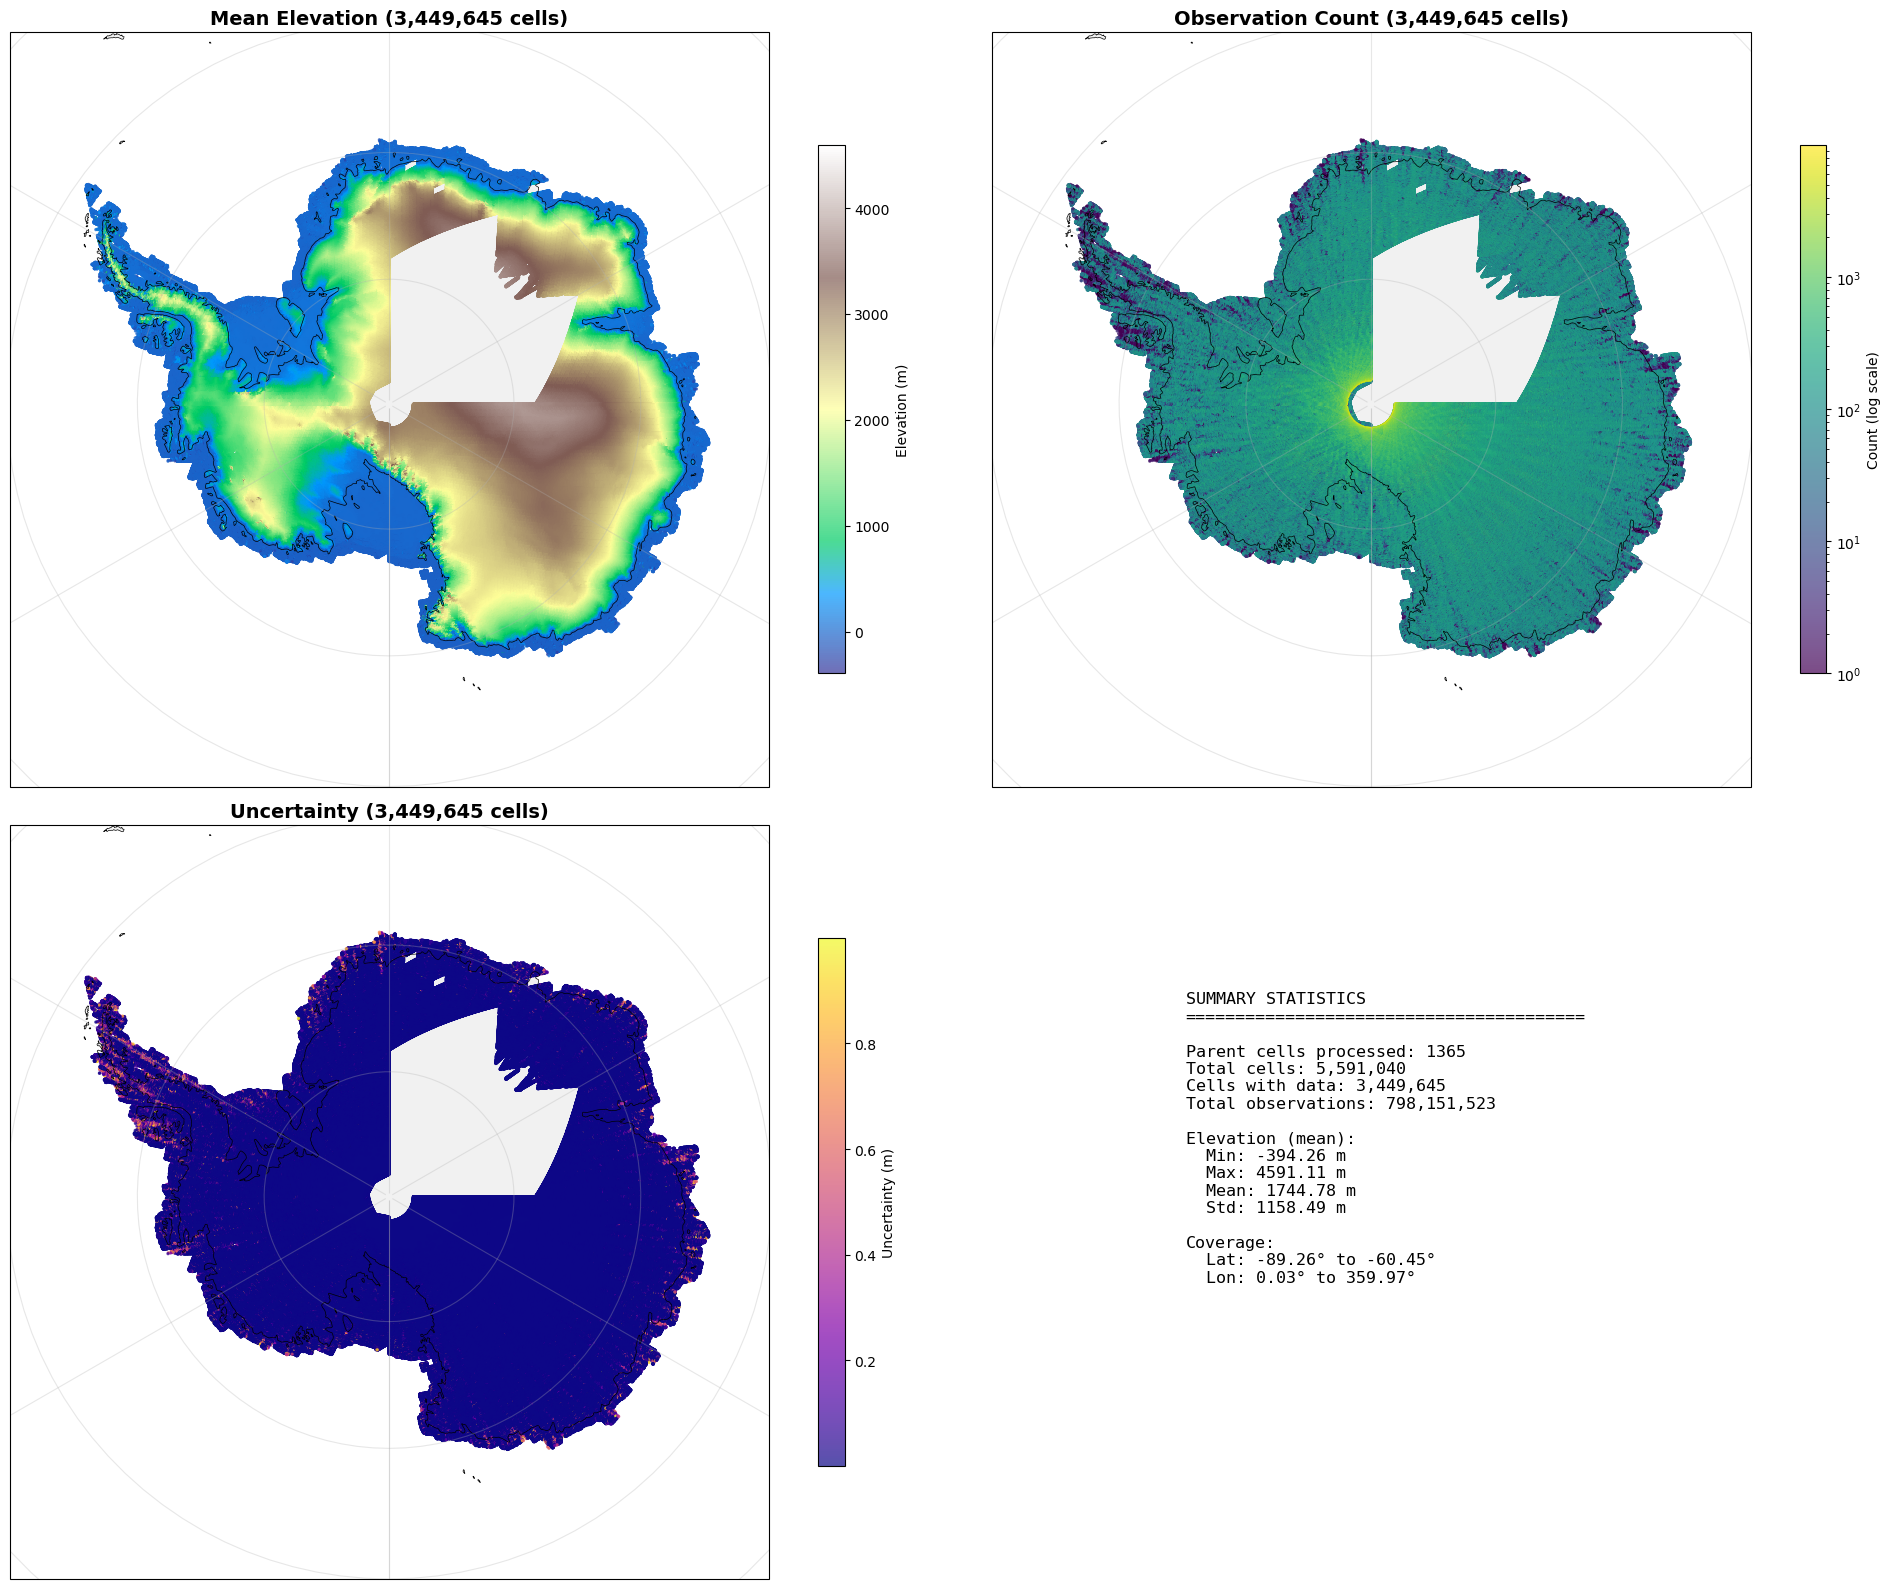


✓ Visualization complete


In [10]:
if len(zarr_paths) > 0 and "ds_combined" in locals():
    # Add lat/lon coords if not present
    if "latitude" not in ds_combined.coords:
        ds_combined = ds_combined.dggs.assign_latlon_coords()

    # Antarctic Polar Stereographic projection
    proj = ccrs.SouthPolarStereo()
    data_crs = ccrs.PlateCarree()

    fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw={"projection": proj})

    # Add Antarctic coastline to all subplots
    for ax in axes.flat:
        ax.coastlines(resolution="50m", linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
        ax.gridlines(draw_labels=False, alpha=0.3)
        ax.set_extent([-180, 180, -90, -60], crs=data_crs)

    # Mean elevation
    ax = axes[0, 0]
    valid = ~np.isnan(ds_combined["h_mean"].values)
    scatter = ax.scatter(
        ds_combined["longitude"].values[valid],
        ds_combined["latitude"].values[valid],
        c=ds_combined["h_mean"].values[valid],
        s=2,
        cmap="terrain",
        alpha=0.7,
        transform=data_crs,
    )
    ax.set_title(f"Mean Elevation ({np.sum(valid):,} cells)", fontsize=14, weight="bold")
    plt.colorbar(scatter, ax=ax, label="Elevation (m)", shrink=0.7)

    # Observation count
    ax = axes[0, 1]
    valid = ds_combined["count"].values > 0
    scatter = ax.scatter(
        ds_combined["longitude"].values[valid],
        ds_combined["latitude"].values[valid],
        c=ds_combined["count"].values[valid],
        s=2,
        cmap="viridis",
        alpha=0.7,
        norm=plt.matplotlib.colors.LogNorm(vmin=1),
        transform=data_crs,
    )
    ax.set_title(f"Observation Count ({np.sum(valid):,} cells)", fontsize=14, weight="bold")
    plt.colorbar(scatter, ax=ax, label="Count (log scale)", shrink=0.7)

    # Uncertainty
    ax = axes[1, 0]
    valid = ~np.isnan(ds_combined["h_sigma"].values)
    scatter = ax.scatter(
        ds_combined["longitude"].values[valid],
        ds_combined["latitude"].values[valid],
        c=ds_combined["h_sigma"].values[valid],
        s=2,
        cmap="plasma",
        alpha=0.7,
        transform=data_crs,
    )
    ax.set_title(f"Uncertainty ({np.sum(valid):,} cells)", fontsize=14, weight="bold")
    plt.colorbar(scatter, ax=ax, label="Uncertainty (m)", shrink=0.7)

    # Summary stats
    ax = axes[1, 1]
    ax.set_visible(False)

    # Create text axes without projection
    text_ax = fig.add_axes(axes[1, 1].get_position())
    text_ax.axis("off")

    stats_text = f"""
SUMMARY STATISTICS
{"=" * 40}

Parent cells processed: {len(zarr_paths)}
Total cells: {len(ds_combined["cell_ids"]):,}
Cells with data: {np.sum(ds_combined["count"].values > 0):,}
Total observations: {ds_combined["count"].sum().values:,}

Elevation (mean):
  Min: {ds_combined["h_mean"].min().values:.2f} m
  Max: {ds_combined["h_mean"].max().values:.2f} m
  Mean: {ds_combined["h_mean"].mean().values:.2f} m
  Std: {ds_combined["h_mean"].std().values:.2f} m

Coverage:
  Lat: {ds_combined["latitude"].min().values:.2f}° to {ds_combined["latitude"].max().values:.2f}°
  Lon: {ds_combined["longitude"].min().values:.2f}° to {ds_combined["longitude"].max().values:.2f}°
    """

    text_ax.text(0.1, 0.5, stats_text, fontsize=12, family="monospace", verticalalignment="center")

    plt.tight_layout()
    plt.show()

    print("\n✓ Visualization complete")
else:
    print("⚠️  No data available for visualization")

## 11. Cleanup

In [18]:
# Close client and shutdown cluster
client.close()
cluster.shutdown()

print("✓ Cluster shut down")

✓ Cluster shut down
